In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils import resample, shuffle

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, Dropout, Bidirectional, LSTM, GlobalMaxPool1D, Dense

import gensim

In [2]:
import warnings
from collections import Counter, OrderedDict
from pathlib import Path
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import seaborn as sns

In [4]:
from textblob import TextBlob, Word

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline

In [6]:
import lightgbm as lgb
import json
from time import clock, time

In [7]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [8]:
df = pd.read_table('FinancialPhraseBank-v1.0/Sentences_50Agree.txt', delimiter='\r\n')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [9]:
df

,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral"
0,Technopolis plans to develop in stages an area...
1,The international electronic industry company ...
2,With the new production plant the company woul...
3,According to the company 's updated strategy f...
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...,...
4840,LONDON MarketWatch -- Share prices ended lower...
4841,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842,Operating profit fell to EUR 35.4 mn from EUR ...
4843,Net sales of the Paper segment decreased to EU...


In [10]:
values = np.array([df.values[i][0].split('@') for i in range(df.size)])
data = pd.DataFrame({'sentence':values[:, 0], 'sentiment':values[:, 1]})
data.head()

,sentence,sentiment
0,Technopolis plans to develop in stages an area...,neutral
1,The international electronic industry company ...,negative
2,With the new production plant the company woul...,positive
3,According to the company 's updated strategy f...,positive
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,positive


In [11]:
data.head(5)

,sentence,sentiment
0,Technopolis plans to develop in stages an area...,neutral
1,The international electronic industry company ...,negative
2,With the new production plant the company woul...,positive
3,According to the company 's updated strategy f...,positive
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,positive


In [12]:
data.shape

(4845, 2)

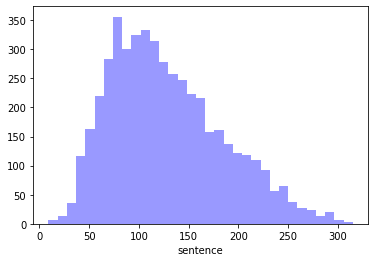

In [13]:
sns.distplot(data['sentence'].str.len(),color='blue',kde=False);

In [14]:
data = data[data['sentence'].str.len()<=200]
data.drop_duplicates(subset=['sentence', 'sentiment'])

,sentence,sentiment
0,Technopolis plans to develop in stages an area...,neutral
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,positive
5,"For the last quarter of 2010 , Componenta 's n...",positive
6,"In the third quarter of 2010 , net sales incre...",positive
7,Operating profit rose to EUR 13.1 mn from EUR ...,positive
...,...,...
4838,Operating result for the 12-month period decre...,negative
4840,LONDON MarketWatch -- Share prices ended lower...,negative
4841,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral
4842,Operating profit fell to EUR 35.4 mn from EUR ...,negative


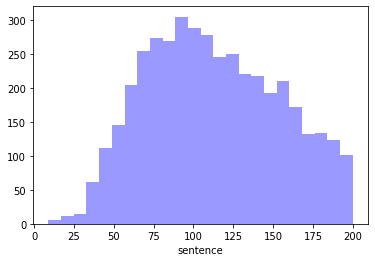

In [15]:
sns.distplot(data['sentence'].str.len(),color='blue',kde=False);

In [16]:
data['sentiment'].value_counts()

neutral     2543
positive    1142
negative     535
Name: sentiment, dtype: int64

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4220 entries, 0 to 4844
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   4220 non-null   object
 1   sentiment  4220 non-null   object
dtypes: object(2)
memory usage: 98.9+ KB


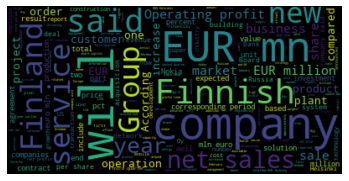

In [18]:
combined_text = " ".join([review for review in data['sentence']])
wordcloud = WordCloud().generate(combined_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

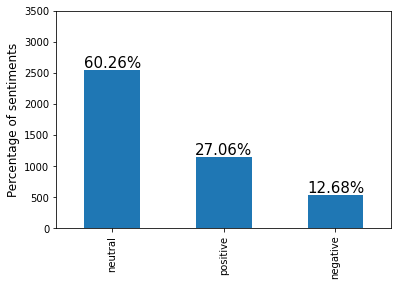

In [19]:
ax = data['sentiment'].value_counts().plot(kind='bar')
ax.set_ylabel('Percentage of sentiments', fontsize=12)
ax.set_yticks(np.arange(0, 3501, 500))
total = data['sentiment'].size
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2., i.get_height() + 40, str(round((i.get_height()/total)*100, 2)) + '%', ha ='center', fontsize=15)
plt.show()

In [20]:
x = data.sentence
y = data.sentiment

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=7)
x_train.shape,y_train.shape

((3376,), (3376,))

In [21]:
pd.value_counts(y_train.values.flatten())

neutral     2034
positive     914
negative     428
dtype: int64

In [22]:
x_train.size,y_train.size

(3376, 3376)

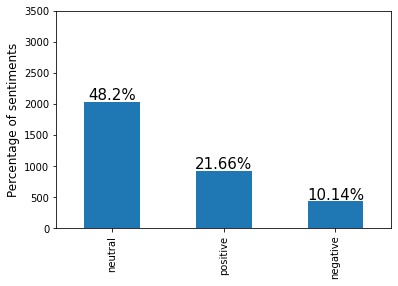

In [23]:
ax = y_train.value_counts().plot(kind='bar')
ax.set_ylabel('Percentage of sentiments', fontsize=12)
ax.set_yticks(np.arange(0, 3501, 500))
total = data['sentiment'].size
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2., i.get_height() + 40, str(round((i.get_height()/total)*100, 2)) + '%', ha ='center', fontsize=15)
plt.show()

In [24]:
#dealing with the imbalanced class 
neu_index = y_train[y_train == 'neutral'].index
pos_index = y_train[y_train == 'positive'].index
neg_index = y_train[y_train == 'negative'].index
x_train_neu, y_train_neu =resample(x_train.loc[neu_index],y_train.loc[neu_index],n_samples=len(pos_index),replace=False,random_state=7)
x_train_neg, y_train_neg =resample(x_train.loc[neg_index],y_train.loc[neg_index],n_samples=len(pos_index),replace=True,random_state=7)

x_train_resample = x_train.loc[pos_index].append([x_train_neu, x_train_neg])
y_train_resample = y_train.loc[pos_index].append([y_train_neu, y_train_neg])

In [25]:
x_train2, y_train2 = shuffle(x_train_resample,y_train_resample, random_state=7)

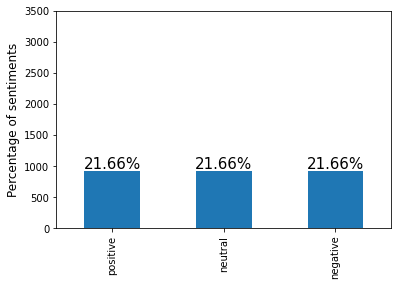

In [26]:
ax = y_train2.value_counts().plot(kind='bar')
ax.set_ylabel('Percentage of sentiments', fontsize=12)
ax.set_yticks(np.arange(0, 3501, 500))
total = data['sentiment'].size
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2., i.get_height() + 40, str(round((i.get_height()/total)*100, 2)) + '%', ha ='center', fontsize=15)
plt.show()

In [27]:
x_train2.size,y_train2.size

(2742, 2742)

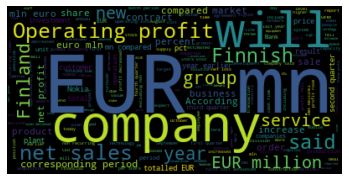

In [28]:
combined_text = " ".join([review for review in x_train2])
wordcloud = WordCloud().generate(combined_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [29]:
#convert the word in sequences 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train2)

x_train2 = tokenizer.texts_to_sequences(x_train2)
x_test = tokenizer.texts_to_sequences(x_test)

word_index = tokenizer.word_index
print("No.of words in corpus : {}".format(len(word_index)))

No.of words in corpus : 6137


In [30]:
word_index.items()

dict_items([('the', 1), ('in', 2), ('of', 3), ('to', 4), ('and', 5), ('a', 6), ('eur', 7), ('for', 8), ('mn', 9), ('from', 10), ("'s", 11), ('is', 12), ('company', 13), ('profit', 14), ('on', 15), ('will', 16), ('1', 17), ('by', 18), ('sales', 19), ('year', 20), ('its', 21), ('net', 22), ('has', 23), ('operating', 24), ('at', 25), ('3', 26), ('with', 27), ('million', 28), ('5', 29), ('as', 30), ('2', 31), ('said', 32), ('be', 33), ('was', 34), ('period', 35), ('finnish', 36), ('0', 37), ('it', 38), ('4', 39), ('quarter', 40), ('mln', 41), ('that', 42), ('m', 43), ('2007', 44), ('2009', 45), ('8', 46), ('6', 47), ('2008', 48), ('7', 49), ('9', 50), ('compared', 51), ('finland', 52), ('are', 53), ('group', 54), ('an', 55), ('loss', 56), ('share', 57), ("''", 58), ('corresponding', 59), ('have', 60), ('new', 61), ('down', 62), ('euro', 63), ('also', 64), ('first', 65), ('up', 66), ('000', 67), ('business', 68), ('been', 69), ('2006', 70), ('decreased', 71), ('2010', 72), ('this', 73), ('2

In [31]:
#pad the sequences to ensure all the vectors have same length 
max_len = np.max([len(x_train2[i]) for i in range(len(x_train2))])
print(max_len)
x_train2= pad_sequences(x_train2, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

46


In [32]:
#encode the target into integers 
le= LabelEncoder()
le.fit(y_train2)
y_train2=le.transform(y_train2)
y_test=le.transform(y_test)

In [33]:
y_train2= to_categorical(y_train2)
y_test = to_categorical(y_test)
n_classes = y_train2.shape[1] #number_of_classes

In [34]:
n_classes

3

In [35]:
#load the wor2vec
word2vec = gensim.models.KeyedVectors.load_word2vec_format("/Users/r.shyaamprasadh/Downloads/GoogleNews-vectors-negative300.bin", binary=True)

In [36]:
def embedding_matrix(model,word_index):
    
    embedding_mat = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        if word in model.index2word:
            embedding_mat[i]= model[word]
            
    return embedding_mat

In [37]:
EMBEDDING_DIM = 300
w2v_matrix = embedding_matrix(word2vec, word_index)
np.save('/Users/r.shyaamprasadh/Downloads/emb_matrix_w2v', w2v_matrix)

In [38]:
print(w2v_matrix )

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.08007812  0.10498047  0.04980469 ...  0.00366211  0.04760742
  -0.06884766]
 [ 0.0703125   0.08691406  0.08789062 ... -0.04760742  0.01446533
  -0.0625    ]
 ...
 [ 0.03637695  0.16601562 -0.05371094 ...  0.12988281  0.01745605
  -0.05444336]
 [ 0.23730469  0.05249023  0.03710938 ...  0.03759766 -0.13378906
   0.02246094]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [39]:
model = Sequential()
model.add(Embedding(len(word_index)+1, EMBEDDING_DIM, weights=[w2v_matrix],
                    trainable=False, input_length=max_len)),model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(200, return_sequences=True), merge_mode='concat'))
model.add(Dropout(0.25))
model.add(GlobalMaxPool1D())
model.add(Dense(50, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 46, 300)           1841400   
_________________________________________________________________
dropout (Dropout)            (None, 46, 300)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 46, 400)           801600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 46, 400)           0         
_________________________________________________________________
global_max_pooling1d (Global (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                20050     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0

In [40]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [41]:
batch_size = 64
epochs = 10
model.fit(x_train2, y_train2, epochs=epochs, batch_size=batch_size, verbose=0)

In [42]:
test_loss, test_acc =model.evaluate(x_test,y_test,batch_size=batch_size)

print("Testing accuracy: {:.1f}".format(test_acc*100))

14/14 [==============================] - 0s 33ms/step - loss: 0.5247 - acc: 0.7891
Testing accuracy: 78.9


In [43]:
y_pred=model.predict(x_test,batch_size=batch_size)

In [44]:
pd.DataFrame(y_pred).head(5)

,0,1,2
0,0.059862,0.900854,0.039284
1,0.973864,0.005927,0.020209
2,0.036722,0.199668,0.763610
3,0.007901,0.691956,0.300143
4,0.096010,0.499122,0.404868


In [45]:
pd.DataFrame(y_test).head(5)

,0,1,2
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0


In [46]:
y_pred= np.argmax(y_pred,axis=1)

In [47]:
y_test= np.argmax(y_test,axis=1)

In [48]:
cm= confusion_matrix(y_test,y_pred)

In [51]:
np.set_printoptions(precision=2)

In [52]:
def plot_confusion_matrix(cm, classes, 
                          title='Confusion matrix', 
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

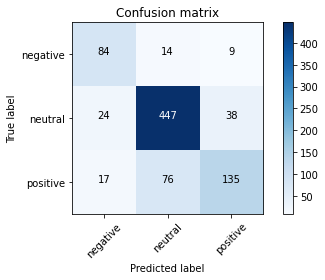

In [53]:
labels = le.classes_.tolist()
plt.figure()
plot_confusion_matrix(cm, classes=labels)

In [54]:
p, r, f1, s = precision_recall_fscore_support(y_test, y_pred, average=None)
results = pd.DataFrame({'1-Precision': p, '2-Recall': r, '3-F1 score': f1, '4-Support': s}, index=labels)
print(results.round(decimals=3))

          1-Precision  2-Recall  3-F1 score  4-Support
negative        0.672     0.785       0.724        107
neutral         0.832     0.878       0.855        509
positive        0.742     0.592       0.659        228


#computation_of_micro_average_ROC and macro_average_ROC
https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

In [65]:
n_classes = 3
lw = 2
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(y_pred))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(y_pred))[:, i])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


In [68]:
from sklearn.metrics import auc
from scipy import interp
from itertools import cycle

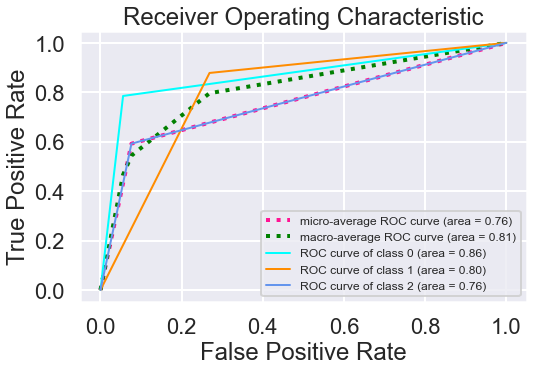

In [76]:
plt.figure(figsize=(8,5))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc=4, prop={'size': 12})
plt.show()
